# Importing The libraries

In [2]:

import os
import time
import random
import pathlib
import itertools
from glob import glob
from tqdm import tqdm_notebook, tnrange


import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate


import warnings
warnings.filterwarnings("ignore")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -u "/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation.zip" -d "/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation"

Archive:  /content/drive/MyDrive/DeepLearning/data/kvasir-segmentation.zip


In [5]:
IMG_CHANNELS, IMG_WIDTH, IMG_HEIGHT = 3, 512, 512

Getting name of image files and appending it to a list.

In [7]:
X = next(os.walk("/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/images"))[2]
y = next(os.walk('/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/masks'))[2]

In [8]:
X_ids = X[:-10]
y_ids = y[:-10]

In [9]:
X_tr = np.zeros((len(X_ids), 256, 256, 3), dtype=np.float32)
y_tr = np.zeros((len(y_ids), 256, 256, 1), dtype=bool)

# Pre-processing:


In [10]:
X_train = np.zeros((len(X_ids), 256, 256, 3), dtype=np.float32)
y_train = np.zeros((len(y_ids), 256, 256, 1), dtype=bool)

for n, id_ in enumerate(X_ids):
    image = tf.keras.preprocessing.image.load_img(f'/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/images/{id_}', target_size=(IMG_HEIGHT, IMG_WIDTH))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)[90:450,150:406]
    image = tf.keras.preprocessing.image.array_to_img(input_arr, ).resize((256, 256))
    X_train[n] = np.array(image)

for n, id_ in enumerate(y_ids):
    image = tf.keras.preprocessing.image.load_img(f'/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/masks/{id_}',
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)[90:450,150:406]
    image = tf.keras.preprocessing.image.array_to_img(input_arr).resize((256, 256))
    y_train[n] = np.array(image)[:, :, np.newaxis]

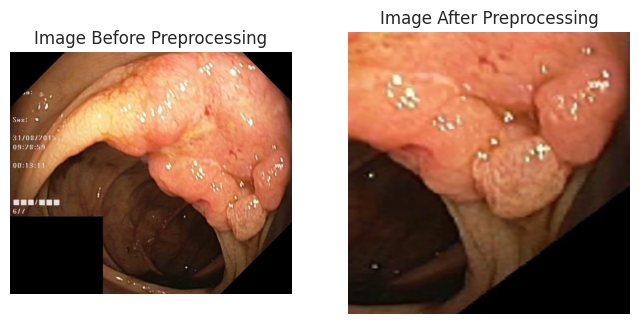

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


IMG_HEIGHT = 256
IMG_WIDTH = 256

id_ = X_ids[0]
image_before = plt.imread(f'/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/images/cju171py4qiha0835u8sl59ds.jpg')
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(image_before)
plt.title('Image Before Preprocessing')
plt.axis('off')


image_after = tf.keras.preprocessing.image.load_img(f'/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/images/cju171py4qiha0835u8sl59ds.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH))
input_arr = tf.keras.preprocessing.image.img_to_array(image_after)[90:450,150:406]
image_after = tf.keras.preprocessing.image.array_to_img(input_arr).resize((IMG_HEIGHT, IMG_WIDTH))
image_after = np.array(image_after)
plt.subplot(1, 2, 2)
plt.imshow(image_after)
plt.title('Image After Preprocessing')
plt.axis('off')

plt.show()


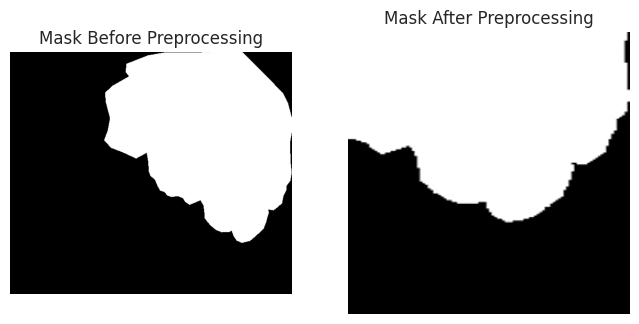

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


id_ = y_ids[0]
mask_before = plt.imread(f'/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/masks/cju171py4qiha0835u8sl59ds.jpg')
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(mask_before, cmap='gray')
plt.title('Mask Before Preprocessing')
plt.axis('off')


image = tf.keras.preprocessing.image.load_img(f'/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/masks/cju171py4qiha0835u8sl59ds.jpg',
                                               target_size=(256, 256), color_mode="grayscale")
input_arr = tf.keras.preprocessing.image.img_to_array(image)[90:450,150:406]
image_after = tf.keras.preprocessing.image.array_to_img(input_arr).resize((256, 256))
image_after = np.array(image_after)
plt.subplot(1, 2, 2)
plt.imshow(image_after[:, :], cmap='gray')
plt.title('Mask After Preprocessing')
plt.axis('off')

plt.show()



Image view after pre-processing.

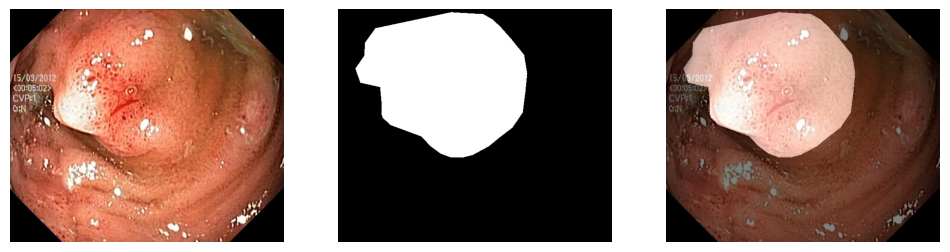

In [ ]:
plt.figure(figsize=(12, 8))
img=cv2.imread('/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg')
msk=cv2.imread('/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/masks/cju0qkwl35piu0993l0dewei2.jpg')

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis(False)

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(msk, cv2.COLOR_BGR2RGB))
plt.axis(False)

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(msk, cv2.COLOR_BGR2RGB),alpha=0.5)
plt.axis(False)
plt.show()

# MODEL:

## UNet model for image segmentation [Semantic].

[Paper](https://arxiv.org/abs/1505.04597)


In [ ]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """

    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [ ]:
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_coef, dice_coef])
# model.compile(Adamax(learning_rate= 0.001), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['activation[0][0]']          
                                                                                              

# Training the model.

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=120)

Epoch 1/120
56/56 [==============================] - 121s 1s/step - loss: 0.6368 - accuracy: 0.6764 - iou_coef: 0.1960 - dice_coef: 0.3270 - val_loss: 11.1591 - val_accuracy: 0.3232 - val_iou_coef: 0.3387 - val_dice_coef: 0.4988
Epoch 2/120
56/56 [==============================] - 46s 817ms/step - loss: 0.6095 - accuracy: 0.6904 - iou_coef: 0.1961 - dice_coef: 0.3273 - val_loss: 1.2739 - val_accuracy: 0.5191 - val_iou_coef: 0.3235 - val_dice_coef: 0.4837
Epoch 3/120
56/56 [==============================] - 46s 821ms/step - loss: 0.6062 - accuracy: 0.6896 - iou_coef: 0.1958 - dice_coef: 0.3267 - val_loss: 0.7868 - val_accuracy: 0.5726 - val_iou_coef: 0.2935 - val_dice_coef: 0.4517
Epoch 4/120
56/56 [==============================] - 47s 835ms/step - loss: 0.6041 - accuracy: 0.6895 - iou_coef: 0.2005 - dice_coef: 0.3334 - val_loss: 0.6944 - val_accuracy: 0.6821 - val_iou_coef: 0.1413 - val_dice_coef: 0.2470
Epoch 5/120
56/56 [==============================] - 46s 824ms/step - loss: 0.604

Plotting history:

In [15]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_iou = np.argmax(iou_coef)
    iou_highest = val_iou[index_iou]
    index_dice = np.argmax(dice_coef)
    dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

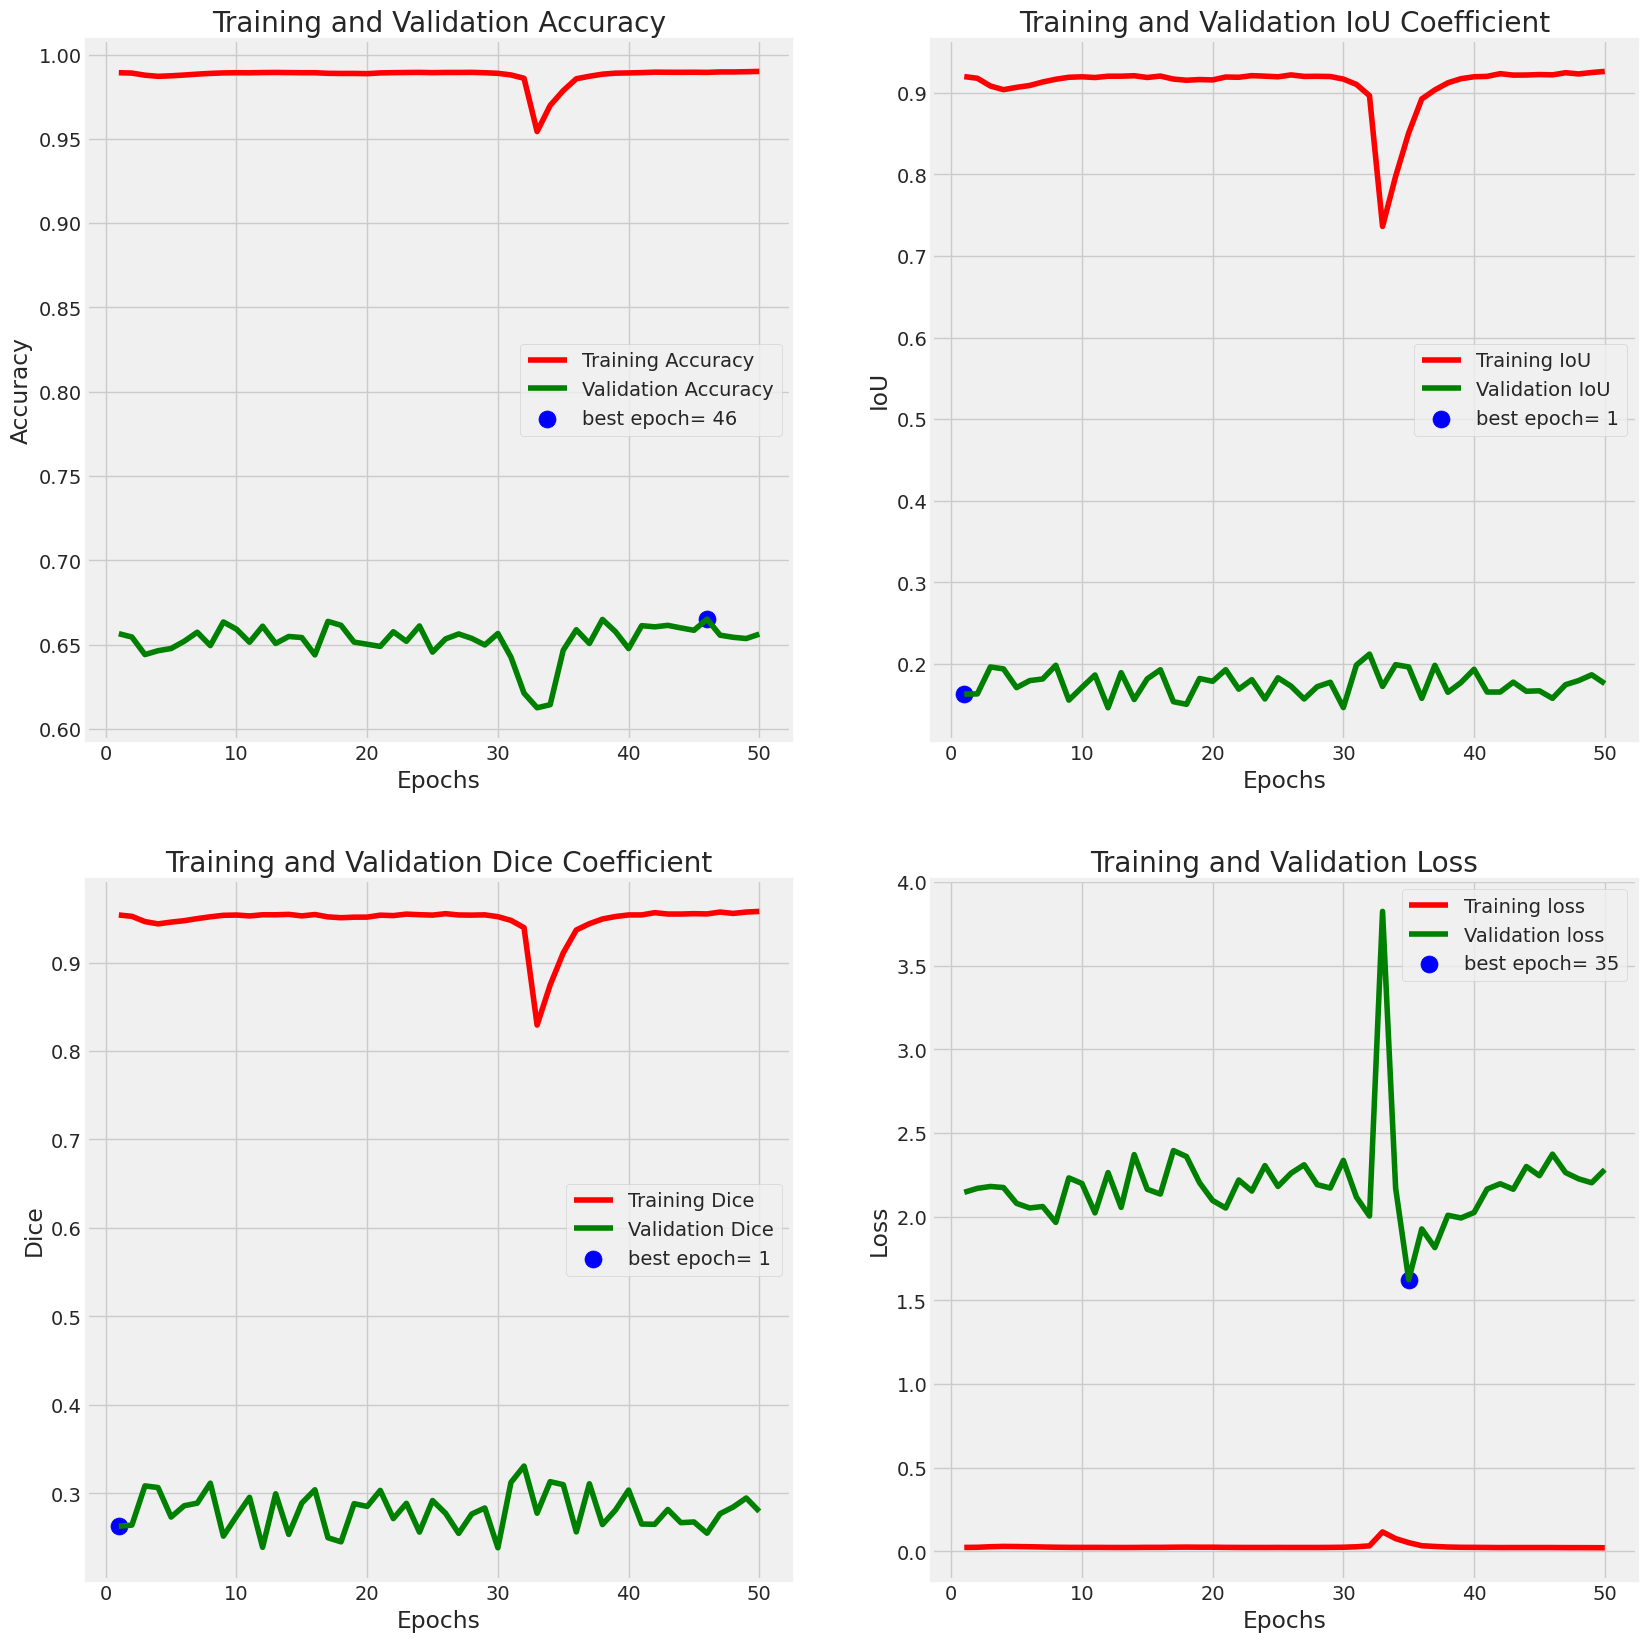

In [16]:
plot_training(history)

## PREDICTED IMAGE:

In [ ]:
img = tf.keras.preprocessing.image.load_img(r"/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/images/cju1b75x63ddl0799sdp0i2j3.jpg", target_size=(256, 256))
input_array = tf.keras.preprocessing.image.img_to_array(img)
input_array = np.array([input_array])  # Convert single image to a batch.
predictions = model.predict(input_array)

1/1 [==============================] - 3s 3s/step


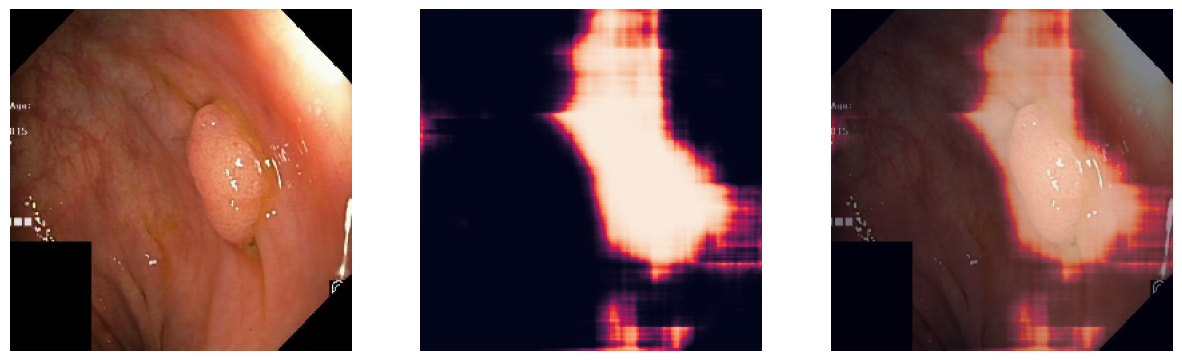

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img))
plt.axis(False)
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(predictions))
plt.axis(False)
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(img))
# plt.imshow(msk,alpha=0.5)
plt.imshow(np.squeeze(predictions), alpha=0.5)
plt.axis(False)
plt.show()

#running again and again

In [34]:
from tensorflow.keras.models import load_model

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice


with tf.keras.utils.custom_object_scope({'iou_coef': iou_coef, 'dice_coef': dice_coef}):
    model = load_model('/content/drive/MyDrive/DeepLearning/data/weights/Kvasir/Kvasir Segmentation_epochs_model.h5')


In [35]:
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=10)


Epoch 1/10
56/56 [==============================] - 52s 794ms/step - loss: 0.0199 - accuracy: 0.9907 - iou_coef: 0.9329 - dice_coef: 0.9623 - val_loss: 2.5148 - val_accuracy: 0.6593 - val_iou_coef: 0.1693 - val_dice_coef: 0.2714
Epoch 2/10
56/56 [==============================] - 44s 791ms/step - loss: 0.0197 - accuracy: 0.9907 - iou_coef: 0.9327 - dice_coef: 0.9621 - val_loss: 2.6102 - val_accuracy: 0.6598 - val_iou_coef: 0.1689 - val_dice_coef: 0.2706
Epoch 3/10
56/56 [==============================] - 44s 795ms/step - loss: 0.0196 - accuracy: 0.9907 - iou_coef: 0.9345 - dice_coef: 0.9636 - val_loss: 2.6272 - val_accuracy: 0.6629 - val_iou_coef: 0.1592 - val_dice_coef: 0.2570
Epoch 4/10
56/56 [==============================] - 44s 793ms/step - loss: 0.0196 - accuracy: 0.9908 - iou_coef: 0.9336 - dice_coef: 0.9629 - val_loss: 2.6112 - val_accuracy: 0.6606 - val_iou_coef: 0.1683 - val_dice_coef: 0.2694
Epoch 5/10
56/56 [==============================] - 44s 793ms/step - loss: 0.0197 - 

In [36]:
save_path = '/content/drive/MyDrive/DeepLearning/data/weights/Kvasir'


save_id = str('Kvasir Segmentation_epochs_model.h5')
model_save_loc = os.path.join(save_path, save_id)


model.save(model_save_loc)
print(f'Model trained for many epochs was saved to Google Drive at: {model_save_loc}')


Model trained for many epochs was saved to Google Drive at: /content/drive/MyDrive/DeepLearning/data/weights/Kvasir/Kvasir Segmentation_epochs_model.h5


In [ ]:
img = tf.keras.preprocessing.image.load_img(r"/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/images/cju1b75x63ddl0799sdp0i2j3.jpg", target_size=(256, 256))
input_array = tf.keras.preprocessing.image.img_to_array(img)
input_array = np.array([input_array])  # Convert single image to a batch.
predictions = model.predict(input_array)

1/1 [==============================] - 0s 70ms/step


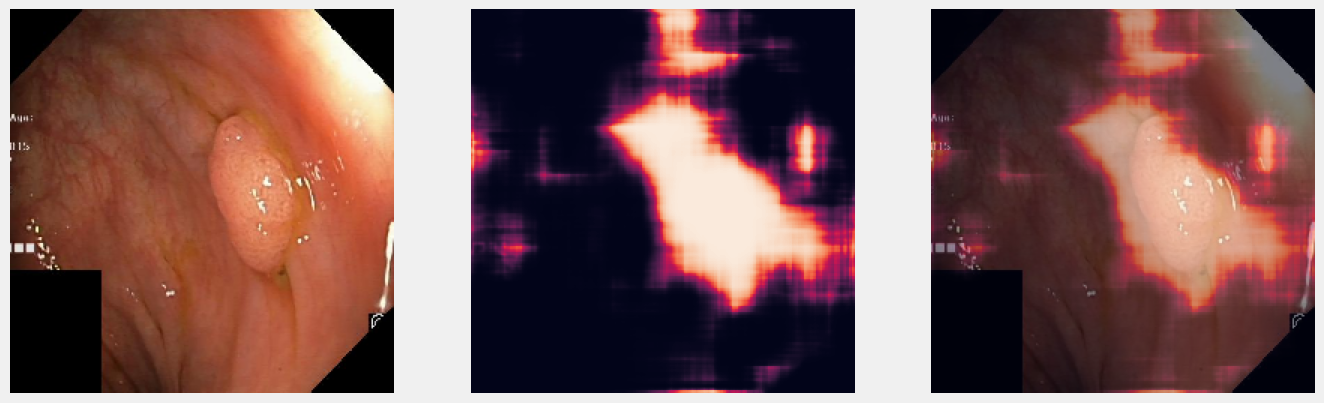

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img))
plt.axis(False)
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(predictions))
plt.axis(False)
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(img))
# plt.imshow(msk,alpha=0.5)
plt.imshow(np.squeeze(predictions), alpha=0.5)
plt.axis(False)
plt.show()

#3

In [ ]:
img = tf.keras.preprocessing.image.load_img(r"/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/images/cju1b75x63ddl0799sdp0i2j3.jpg", target_size=(256, 256))
input_array = tf.keras.preprocessing.image.img_to_array(img)
input_array = np.array([input_array])  # Convert single image to a batch.
predictions = model.predict(input_array)

1/1 [==============================] - 0s 393ms/step


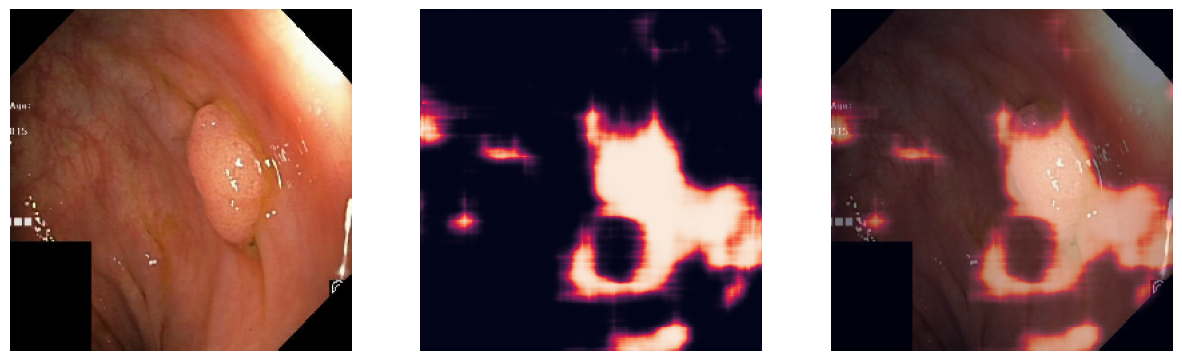

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img))
plt.axis(False)
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(predictions))
plt.axis(False)
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(img))
# plt.imshow(msk,alpha=0.5)
plt.imshow(np.squeeze(predictions), alpha=0.5)
plt.axis(False)
plt.show()

4

In [13]:
img = tf.keras.preprocessing.image.load_img(r"/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/images/cju1b75x63ddl0799sdp0i2j3.jpg", target_size=(256, 256))
input_array = tf.keras.preprocessing.image.img_to_array(img)
input_array = np.array([input_array])  # Convert single image to a batch.
predictions = model.predict(input_array)

1/1 [==============================] - 3s 3s/step


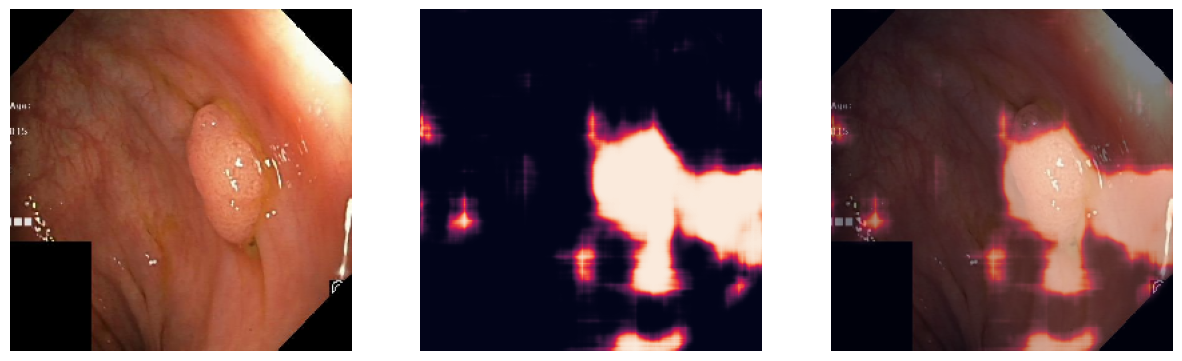

In [14]:
plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img))
plt.axis(False)
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(predictions))
plt.axis(False)
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(img))
# plt.imshow(msk,alpha=0.5)
plt.imshow(np.squeeze(predictions), alpha=0.5)
plt.axis(False)
plt.show()

5

In [37]:
img = tf.keras.preprocessing.image.load_img(r"/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/images/cju1b75x63ddl0799sdp0i2j3.jpg", target_size=(256, 256))
input_array = tf.keras.preprocessing.image.img_to_array(img)
input_array = np.array([input_array])  # Convert single image to a batch.
predictions = model.predict(input_array)

1/1 [==============================] - 0s 446ms/step


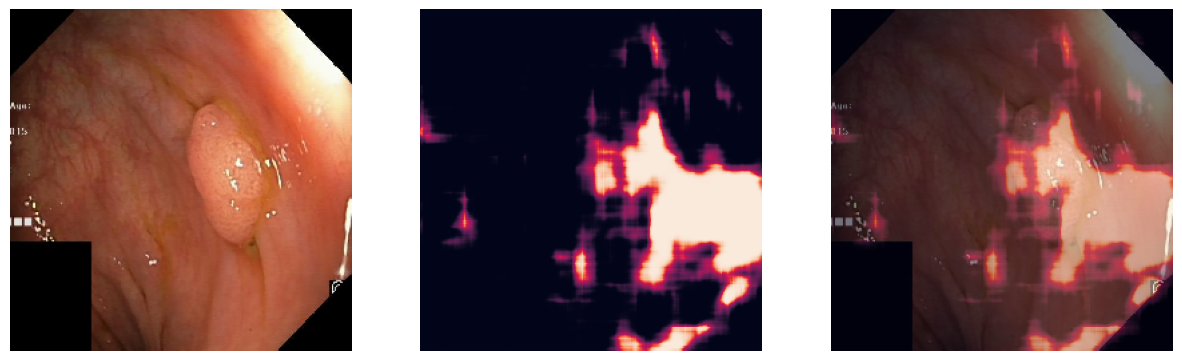

In [38]:
plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img))
plt.axis(False)
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(predictions))
plt.axis(False)
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(img))
# plt.imshow(msk,alpha=0.5)
plt.imshow(np.squeeze(predictions), alpha=0.5)
plt.axis(False)
plt.show()

#dummy

## Model Testing

In [ ]:
segmentation_model = load_model('Kvasir Segmentation model.h5', compile=False)
segmentation_model.compile(Adamax(learning_rate=0.001), loss=dice_loss, metrics=['accuracy', iou_coef, dice_coef])

In [ ]:
img = tf.keras.preprocessing.image.load_img(r"/content/drive/MyDrive/DeepLearning/data/kvasir-segmentation/kvasir-seg/Kvasir-SEG/images/cju0s2a9ekvms080138tjjpxr.jpg", target_size=(256, 256))
input_array = tf.keras.preprocessing.image.img_to_array(img)
input_array = np.array([input_array])  # Convert single image to a batch.
predictions = segmentation_model.predict(input_array)

1/1 [==============================] - 0s 430ms/step


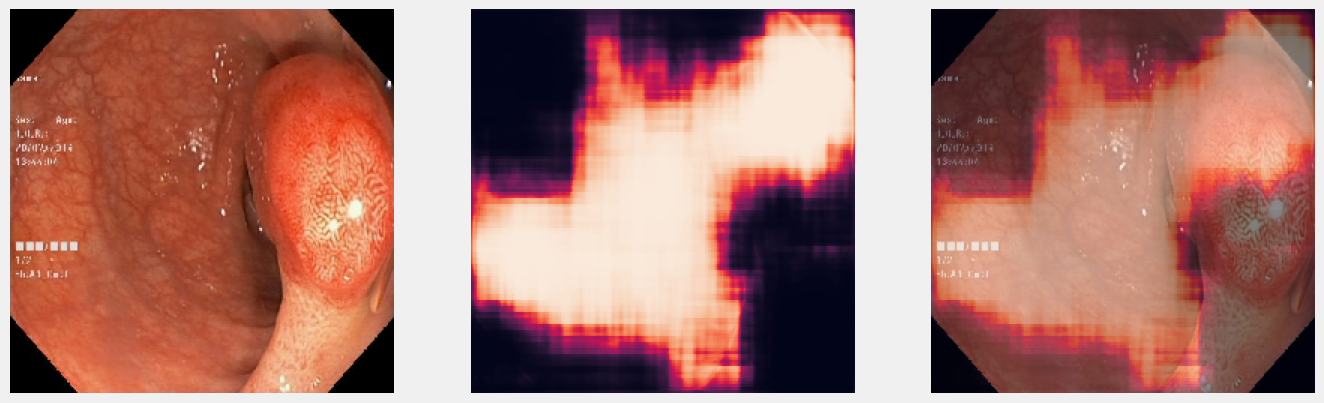

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img))
plt.axis(False)
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(predictions))
plt.axis(False)
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(img))
# plt.imshow(msk,alpha=0.5)
plt.imshow(np.squeeze(predictions), alpha=0.5)
plt.axis(False)
plt.show()